# Логістична регресія. Класифікація. Титанік

Курс: "Математичне моделювання в R"

---

In [1]:
# install.packages("mice")
# install.packages("Amelia")
# install.packages("InformationValue")

## Dataset overview

У даному навчальному матеріалі використано класичний приклад даних з інформацією про пасажирів корабля Титанік.

Source: https://github.com/Geoyi/Cleaning-Titanic-Data

**Dataset description:**

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

**Data Fields:**

|Variable|Definition|Key|
|---|---|---|
|survival|Survival (**TARGET**)|0 = No, 1 = Yes
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd||
|sex|Sex||
|Age|Age in years||
|sibsp|# of siblings / spouses aboard the Titanic||
|parch|# of parents / children aboard the Titanic||
|ticket|Ticket number||
|fare|Passenger fare||
|cabin|Cabin number||
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|


In [2]:
# read local
titanic_data <- read.csv("https://raw.githubusercontent.com/Geoyi/Cleaning-Titanic-Data/master/titanic_original.csv", na.strings = c("")) # empty strings is missing data and wiil be replaced with NA
head(titanic_data)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>
1,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NA,"St Louis, MO"
2,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NA,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NA,NA,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NA,135,"Montreal, PQ / Chesterville, ON"
5,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NA,NA,"Montreal, PQ / Chesterville, ON"
6,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NA,"New York, NY"


Переглянемо структуру даних:

In [3]:
str(titanic_data)

'data.frame':	1310 obs. of  14 variables:
 $ pclass   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ survived : int  1 1 0 0 0 1 1 0 1 0 ...
 $ name     : chr  "Allen, Miss. Elisabeth Walton" "Allison, Master. Hudson Trevor" "Allison, Miss. Helen Loraine" "Allison, Mr. Hudson Joshua Creighton" ...
 $ sex      : chr  "female" "male" "female" "male" ...
 $ age      : num  29 0.917 2 30 25 ...
 $ sibsp    : int  0 1 1 1 1 0 1 0 2 0 ...
 $ parch    : int  0 2 2 2 2 0 0 0 0 0 ...
 $ ticket   : chr  "24160" "113781" "113781" "113781" ...
 $ fare     : num  211 152 152 152 152 ...
 $ cabin    : chr  "B5" "C22 C26" "C22 C26" "C22 C26" ...
 $ embarked : chr  "S" "S" "S" "S" ...
 $ boat     : chr  "2" "11" NA NA ...
 $ body     : int  NA NA NA 135 NA NA NA NA NA 22 ...
 $ home.dest: chr  "St Louis, MO" "Montreal, PQ / Chesterville, ON" "Montreal, PQ / Chesterville, ON" "Montreal, PQ / Chesterville, ON" ...


Значення показників вибірки:

* _survival_ – "клас виживання" (0 = No; 1 = Yes)
* _pclass_ – клас пасажирів (1 = 1st; 2 = 2nd; 3 = 3rd)
* ~~_name_~~ – ім’я
* _sex_ - стать
* _age_ - вік
* _sibsp_ – кількість членів сім'ї на борту (братів, сестер, подружжя)
* _parch_ – кількість дітей або батьків на борту
* ~~_ticket_~~ – номер квитка
* _fare_ – вартість 
* _cabin_ – номер(и)
* _embarked_ – порт посадки на судно (C = Cherbourg; Q = Queenstown; S = Southampton)
* ~~_boat_~~ – борт на якому відпливав під час порятунку (якщо врятований)
* ~~_body_~~ – ідентифікаційни номер тіла
* ~~_home.dest_~~ – місце доставки пасажира

Детальніше: http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf.

Закреслені поля надалі будуть видалені з датасету для моделювання.

---

## Data preprocessing

### Remove unused columns

Lets remove columns: 
- [x] `name` - just string
- [x] `ticket` - it can be useful to analyze numbers and check if 
- [x] `boat` - if boat is not missing - survived, we cannot use it
- [x] `body` - if body is not missing - not survived, cant use it
- [x] `home.dest` - just text

In [4]:
suppressMessages(library(dplyr)) # filter()
titanic_data <- titanic_data |>
    select(-c("name", "ticket", "boat", "body", "home.dest"))
head(titanic_data)

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked
,<int>,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<chr>,<chr>
1,1,1,female,29.0000,0,0,211.3375,B5,S
2,1,1,male,0.9167,1,2,151.5500,C22 C26,S
3,1,0,female,2.0000,1,2,151.5500,C22 C26,S
4,1,0,male,30.0000,1,2,151.5500,C22 C26,S
5,1,0,female,25.0000,1,2,151.5500,C22 C26,S
6,1,1,male,48.0000,0,0,26.5500,E12,S


---

In [5]:
summary(titanic_data)

     pclass         survived         sex                 age         
 Min.   :1.000   Min.   :0.000   Length:1310        Min.   : 0.1667  
 1st Qu.:2.000   1st Qu.:0.000   Class :character   1st Qu.:21.0000  
 Median :3.000   Median :0.000   Mode  :character   Median :28.0000  
 Mean   :2.295   Mean   :0.382                      Mean   :29.8811  
 3rd Qu.:3.000   3rd Qu.:1.000                      3rd Qu.:39.0000  
 Max.   :3.000   Max.   :1.000                      Max.   :80.0000  
 NA's   :1       NA's   :1                          NA's   :264      
     sibsp            parch            fare            cabin          
 Min.   :0.0000   Min.   :0.000   Min.   :  0.000   Length:1310       
 1st Qu.:0.0000   1st Qu.:0.000   1st Qu.:  7.896   Class :character  
 Median :0.0000   Median :0.000   Median : 14.454   Mode  :character  
 Mean   :0.4989   Mean   :0.385   Mean   : 33.295                     
 3rd Qu.:1.0000   3rd Qu.:0.000   3rd Qu.: 31.275                     
 Max.   :8.000

---

### Check missing data

Для оцінки кількості пропусків побудуємо матрицю та мапу:


Attaching package: 'mice'


The following object is masked from 'package:stats':

    filter


The following objects are masked from 'package:base':

    cbind, rbind




,pclass,survived,sex,sibsp,parch,fare,embarked,age,cabin,
270,1,1,1,1,1,1,1,1,1,0
773,1,1,1,1,1,1,1,1,0,1
23,1,1,1,1,1,1,1,0,1,1
240,1,1,1,1,1,1,1,0,0,2
2,1,1,1,1,1,1,0,1,1,1
1,1,1,1,1,1,0,1,1,0,2
1,0,0,0,0,0,0,0,0,0,9
,1,1,1,1,1,2,3,264,1015,1289


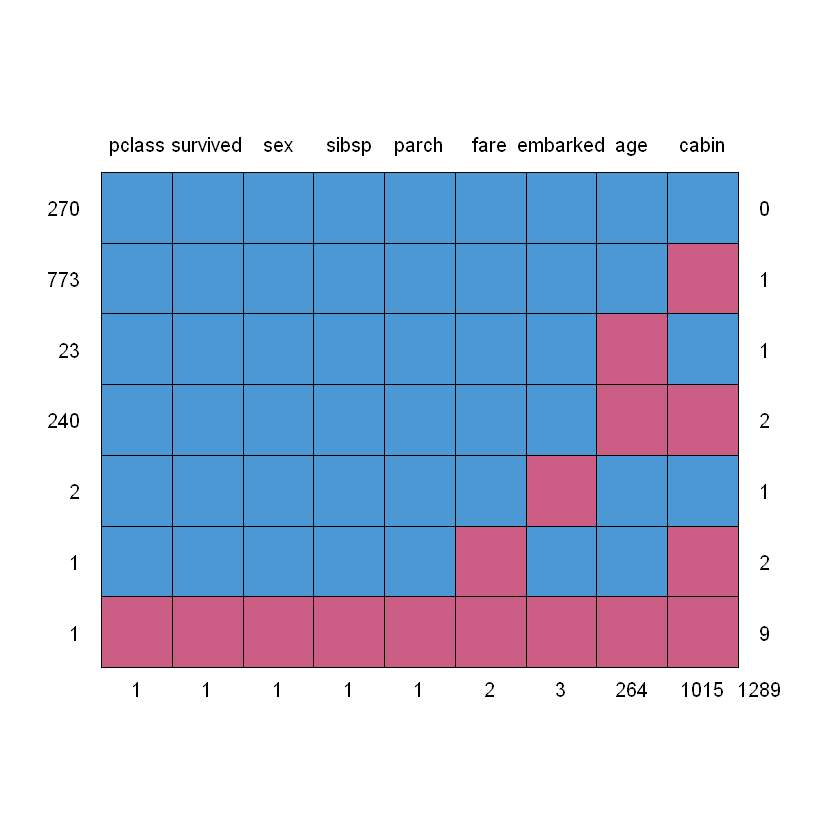

In [6]:
suppressMessages(library(mice))
md.pattern(titanic_data)

Loading required package: Rcpp

## 
## Amelia II: Multiple Imputation
## (Version 1.8.0, built: 2021-05-26)
## Copyright (C) 2005-2022 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 



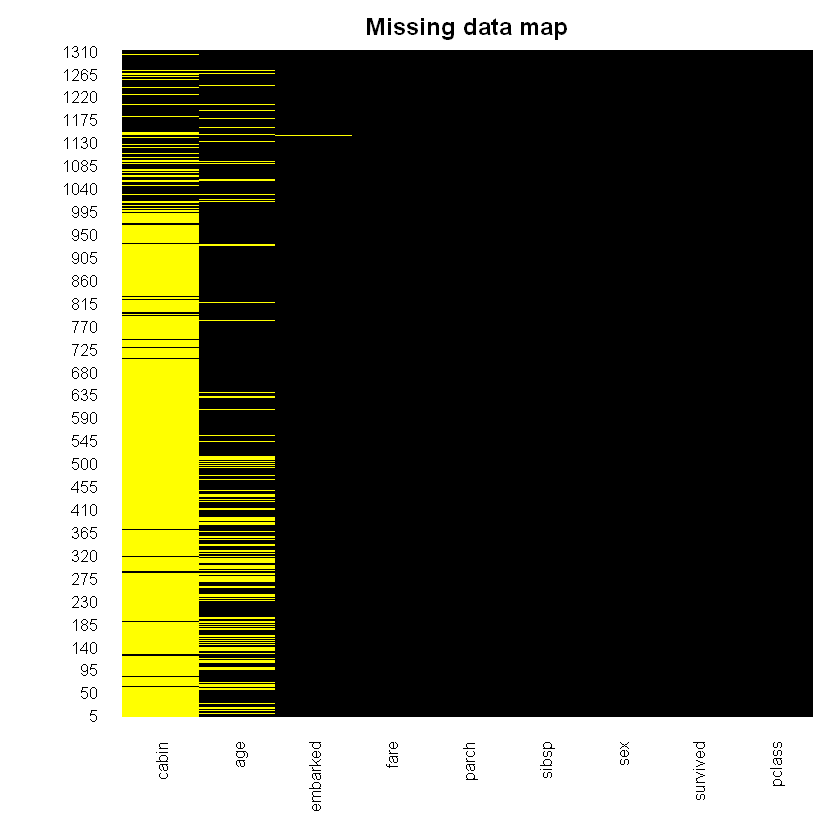

In [7]:
suppressMessages(library(Amelia))
missmap(titanic_data, main = 'Missing data map', col = c('yellow', 'black'), legend = FALSE)

One more way to check where missing data is present with `saplly()`:

In [8]:
sapply(titanic_data, function(x) sum(is.na(x)))

pclass survived      sex      age    sibsp    parch     fare    cabin 
       1        1        1      264        1        1        2     1015 
embarked 
       3

In [9]:
# Lets check where survived is NA, target should be finite
titanic_data %>% filter(is.na(survived))
# looks like its wrong line in data

pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked
<int>,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<chr>,<chr>
NA,NA,NA,NA,NA,NA,NA,NA,NA


In [10]:
# lets remove this row
titanic_data <- titanic_data %>% filter(!is.na(survived))
sapply(titanic_data, function(x) sum(is.na(x)))

pclass survived      sex      age    sibsp    parch     fare    cabin 
       0        0        0      263        0        0        1     1014 
embarked 
       2

<div class="alert alert-danger">We will replace all missing data on the next stages for: `fare`, `cabin`, `age`, `embarked`.</div>

### Visual analysis

In [11]:
library(ggplot2) # for plots
library(gmodels) # for CrossTable

**Survived**


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  1309 

 
          |         0 |         1 | 
          |-----------|-----------|
          |       809 |       500 | 
          |     0.618 |     0.382 | 
          |-----------|-----------|



 


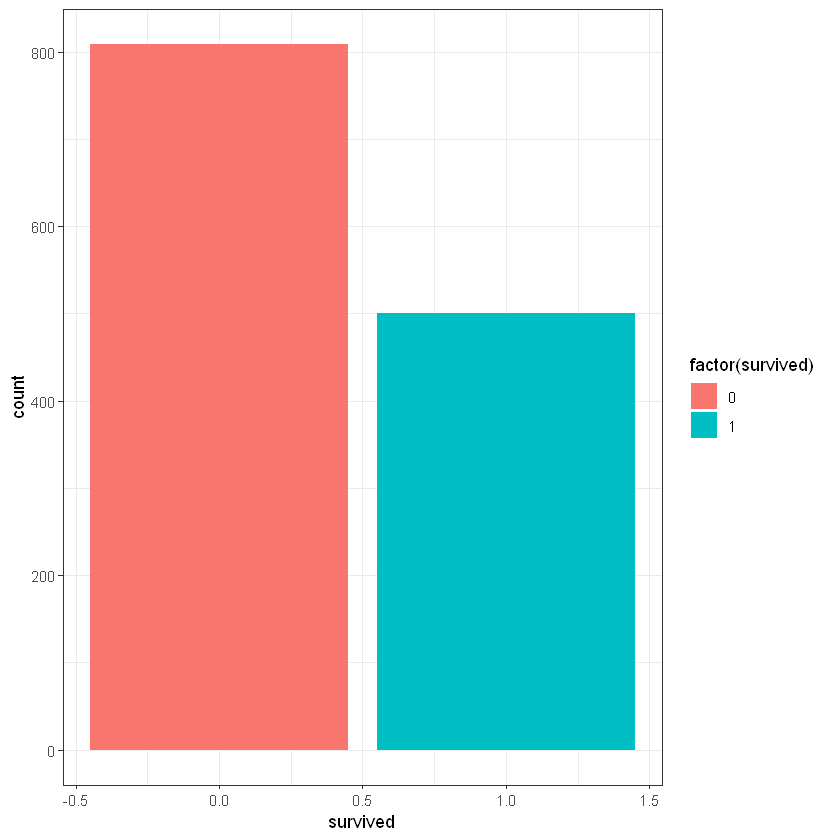

In [12]:
CrossTable(titanic_data$survived)
ggplot(titanic_data, aes(survived)) + geom_bar(aes(fill = factor(survived))) + theme_bw()

**Крос-таблиця survived vs pclass**


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  1309 

 
                      | titanic_data$pclass 
titanic_data$survived |         1 |         2 |         3 | Row Total | 
----------------------|-----------|-----------|-----------|-----------|
                    0 |       123 |       158 |       528 |       809 | 
                      |    29.411 |     1.017 |    18.411 |           | 
                      |     0.152 |     0.195 |     0.653 |     0.618 | 
                      |     0.381 |     0.570 |     0.745 |           | 
                      |     0.094 |     0.121 |     0.403 |           | 
----------------------|-----------|-----------|-----------|-----------|
                    1 |       200 |       119 |       181 |       500 | 
                      |    47.587 |     1.

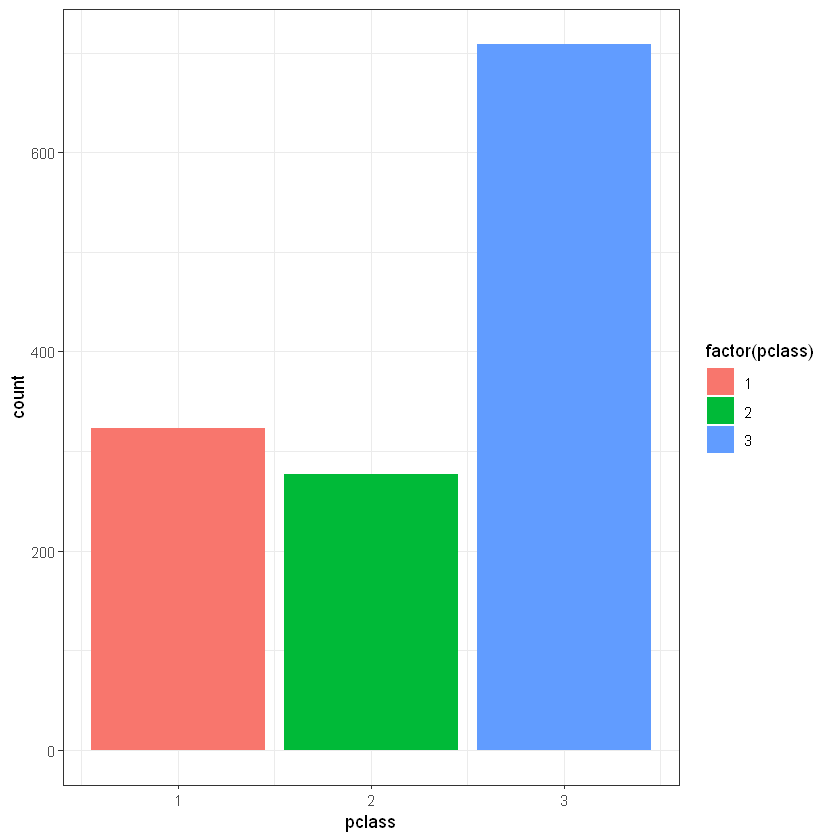

In [13]:
CrossTable(titanic_data$survived, titanic_data$pclass)
ggplot(titanic_data, aes(pclass)) + geom_bar(aes(fill = factor(pclass)))+ theme_bw()

**sex**

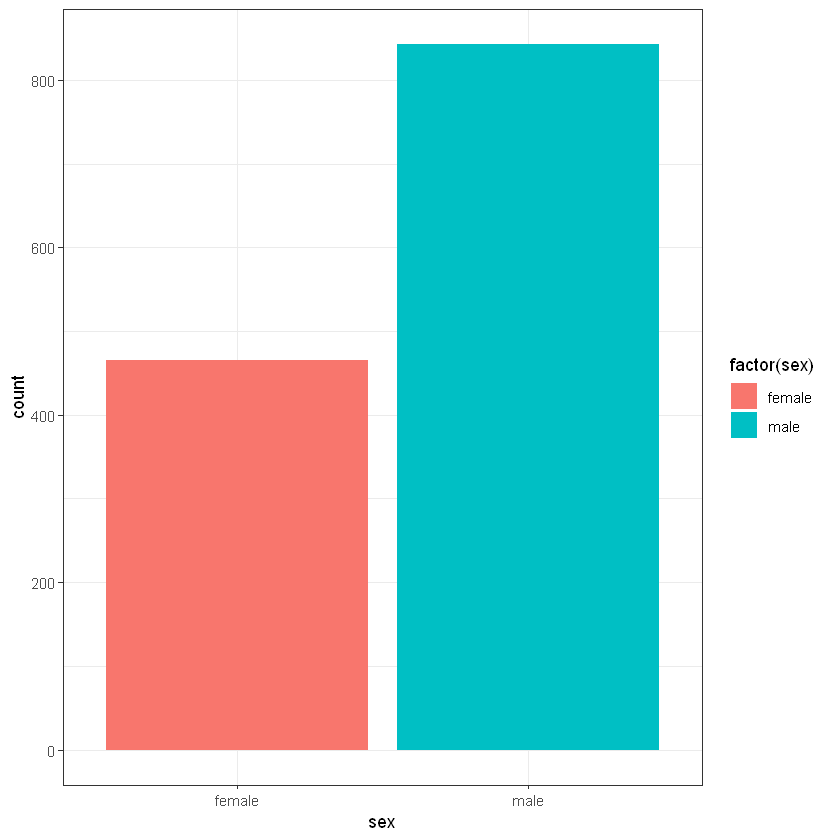

In [14]:
ggplot(titanic_data, aes(x = sex)) + geom_bar(aes(fill = factor(sex))) + theme_bw()

**Age***

Warning message:
"Removed 263 rows containing non-finite values (stat_bin)."


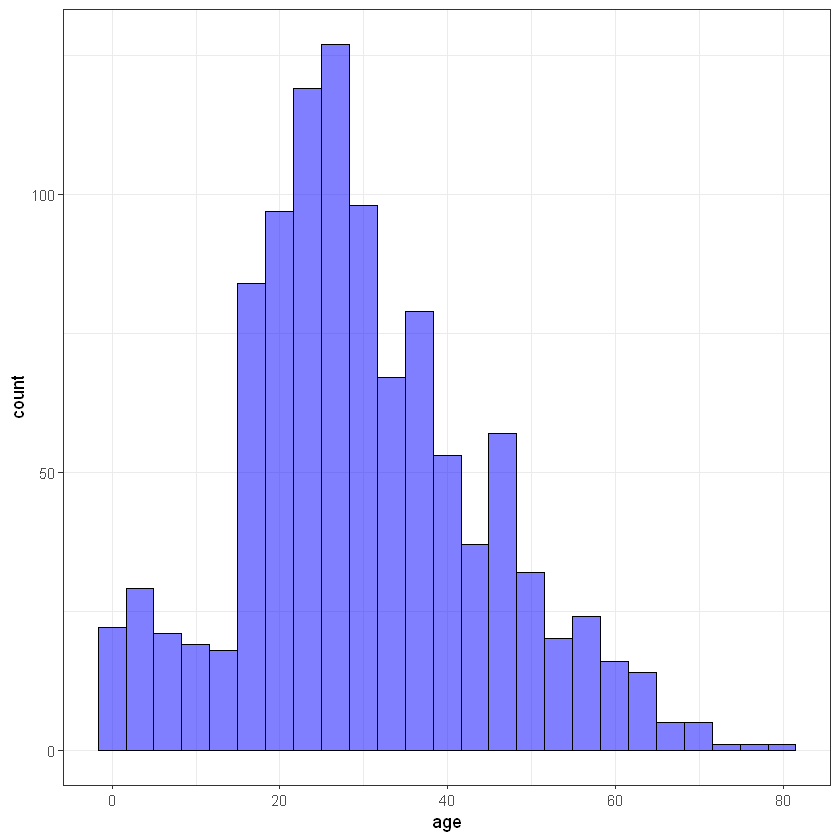

In [15]:
ggplot(titanic_data, aes(age)) + geom_histogram(bins = 25, alpha = 0.5, fill = 'blue', color='black')  + theme_bw()

**fare**

Warning message:
"Removed 1 rows containing non-finite values (stat_bin)."


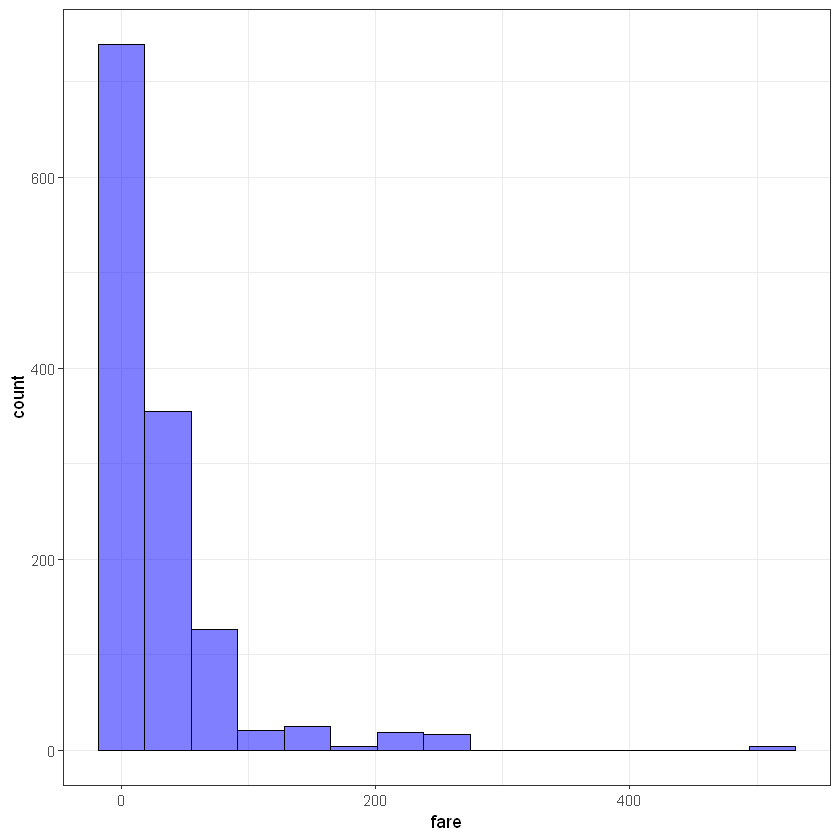

In [16]:
ggplot(titanic_data, aes(fare)) + geom_histogram(bins = 15, alpha = 0.5, fill = 'blue', color='black')+ theme_bw()

**sibsp**

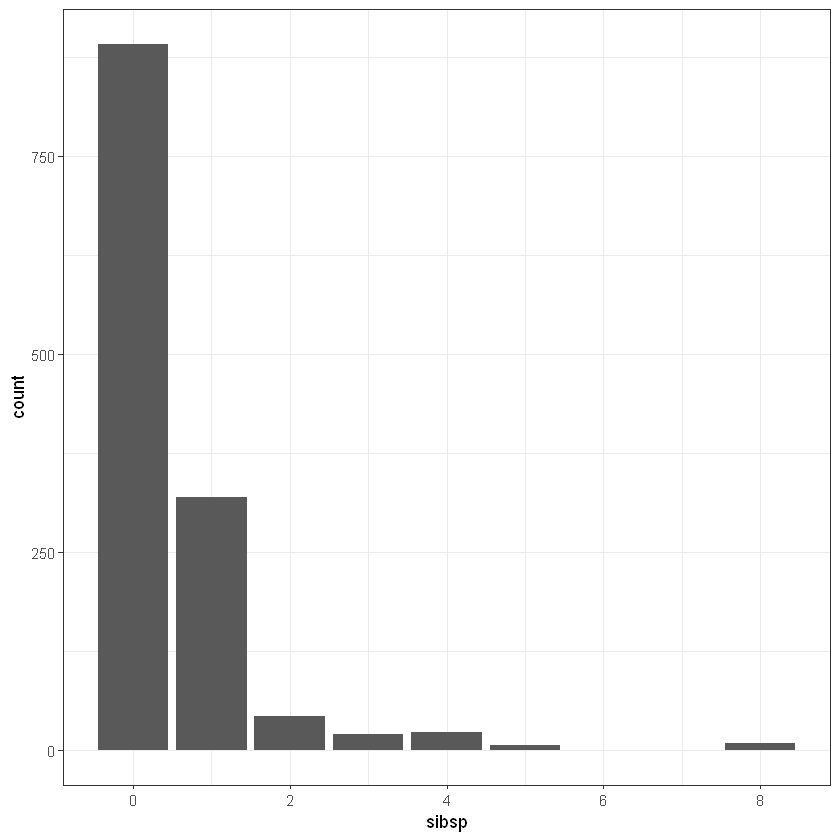

In [17]:
ggplot(titanic_data, aes(sibsp)) + geom_bar()+ theme_bw()

**parch**

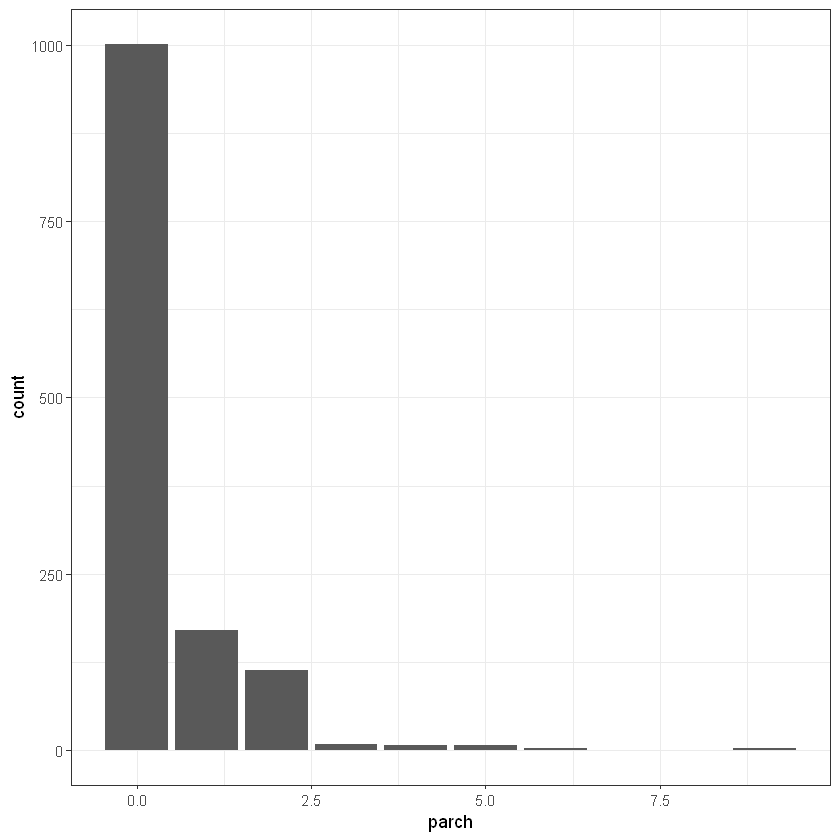

In [18]:
ggplot(titanic_data, aes(parch)) + geom_bar()+ theme_bw()

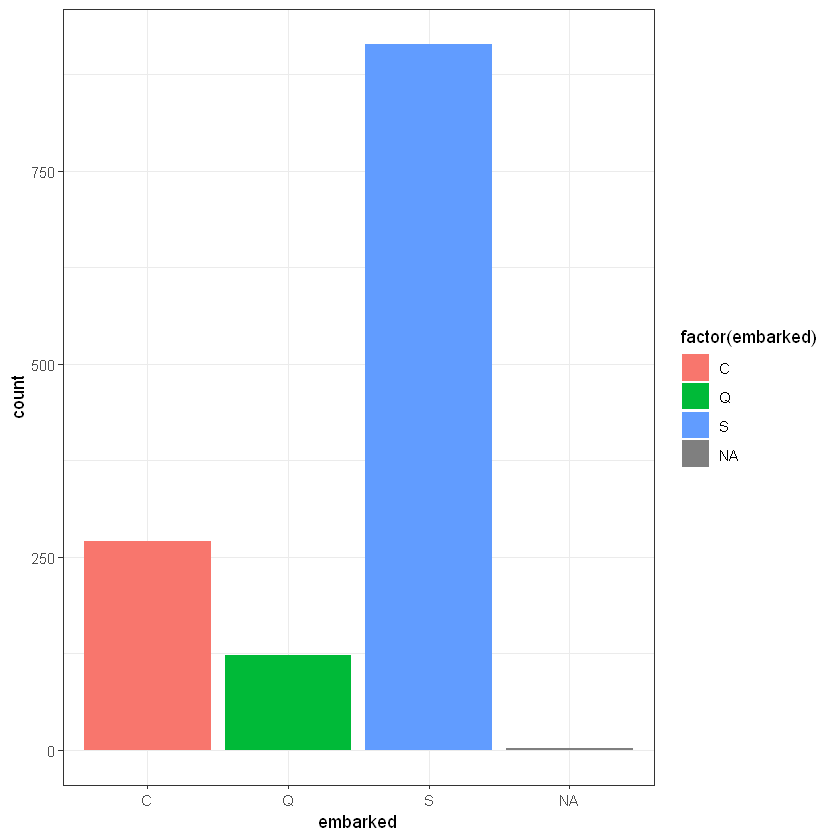

In [19]:
ggplot(titanic_data, aes(embarked)) + geom_bar(aes(fill = factor(embarked)))+ theme_bw()

# it looks like S the most popular value in embarked, so it could be good idea to replace 1 missing with S

---

## Splitting data

Lest split out dataset for test and train

In [20]:
set.seed(1) # seed
library(caTools)
split <- sample.split(titanic_data$survived, SplitRatio = 0.7)
titanic_train <- subset(titanic_data, split == TRUE)
titanic_test <- subset(titanic_data, split == FALSE)

library(gmodels)
CrossTable(titanic_train$survived)
CrossTable(titanic_test$survived) # its splitted by the same proportions


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  916 

 
          |         0 |         1 | 
          |-----------|-----------|
          |       566 |       350 | 
          |     0.618 |     0.382 | 
          |-----------|-----------|



 

 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  393 

 
          |         0 |         1 | 
          |-----------|-----------|
          |       243 |       150 | 
          |     0.618 |     0.382 | 
          |-----------|-----------|



 


---

## Missing replacement

Missing data replacement should have base points for each parameter. 

So, we will fix data for replacement from train and implement it to both train and test.

In [21]:
head(titanic_train)

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked
,<int>,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<chr>,<chr>
1,1,1,female,29.0000,0,0,211.3375,B5,S
2,1,1,male,0.9167,1,2,151.5500,C22 C26,S
3,1,0,female,2.0000,1,2,151.5500,C22 C26,S
4,1,0,male,30.0000,1,2,151.5500,C22 C26,S
5,1,0,female,25.0000,1,2,151.5500,C22 C26,S
6,1,1,male,48.0000,0,0,26.5500,E12,S


In [22]:
# check missing
sapply(titanic_train, function(x) sum(is.na(x)))
sapply(titanic_test, function(x) sum(is.na(x)))

pclass survived      sex      age    sibsp    parch     fare    cabin 
       0        0        0      182        0        0        1      703 
embarked 
       1

pclass survived      sex      age    sibsp    parch     fare    cabin 
       0        0        0       81        0        0        0      311 
embarked 
       1

Створюємо dummy-змінну, що буде вказути на наявність запису про каюту у пасажира `1/0`:

In [23]:
# train
titanic_train <- titanic_train %>%
    mutate(hascabin = ifelse(!is.na(cabin), 1, 0)) %>%
    select(-cabin) # remove cabin column

titanic_test <- titanic_test %>%
    mutate(hascabin = ifelse(!is.na(cabin), 1, 0)) %>%
    select(-cabin) # remove cabin column

Заповнюємо дані пропусків вартості квитка `fare`. Замінюємо `NA` на середнє значення вартості квитка:

In [24]:
avg_fare <- round(mean(titanic_data$fare, na.rm = TRUE),4)
avg_fare

# lets study new function from tidyr replace NA
library(tidyr)
titanic_train <- titanic_train %>% 
    mutate(fare = replace_na(fare, avg_fare))

# there are no missing in test$fare

any(is.na(titanic_train$fare)) # check for missing
any(is.na(titanic_test$fare))

[1] 33.2955

[1] FALSE

[1] FALSE

Заповнюємо пропуски для порту посадки (`embarked`). Варіантом для заміни оберемо найпопулярнішйи варінт значення, той який зустрічається частіше за інші. Скористаємося показником `МОДА`. З попереднього аналізу відомо, що таким показником є `S`. Проте варто написати універсальну функцію, що буде сама відбирати значення:

In [25]:
getmode <- function(v) {
  uniqv <- unique(v) # select all unique values
  uniqv[which.max(tabulate(match(v, uniqv)))] # select value that included most times
}

In [26]:
# get the moda
embarked_moda <- getmode(titanic_data$embarked)
embarked_moda # its `S`

[1] "S"

In [27]:
titanic_train <- titanic_train %>% 
    mutate(embarked = replace_na(embarked, embarked_moda))

titanic_test <- titanic_test %>% 
    mutate(embarked = replace_na(embarked, embarked_moda))

any(is.na(titanic_train$embarked)) # check for missing
any(is.na(titanic_test$embarked))

[1] FALSE

[1] FALSE

Для заміни пропусків по віку (age) використаємо показник “Клас пасажира” (pclass). Обчислимо середній вік пасажирів кожного класу і замінимо пропуски з урахуванням цієї інформації. Тобто для усіх пасажирів 1-го класу замінимо пропуски середнім по пасажирах середнього класу і т.д.

Warning message:
"Removed 182 rows containing non-finite values (stat_boxplot)."


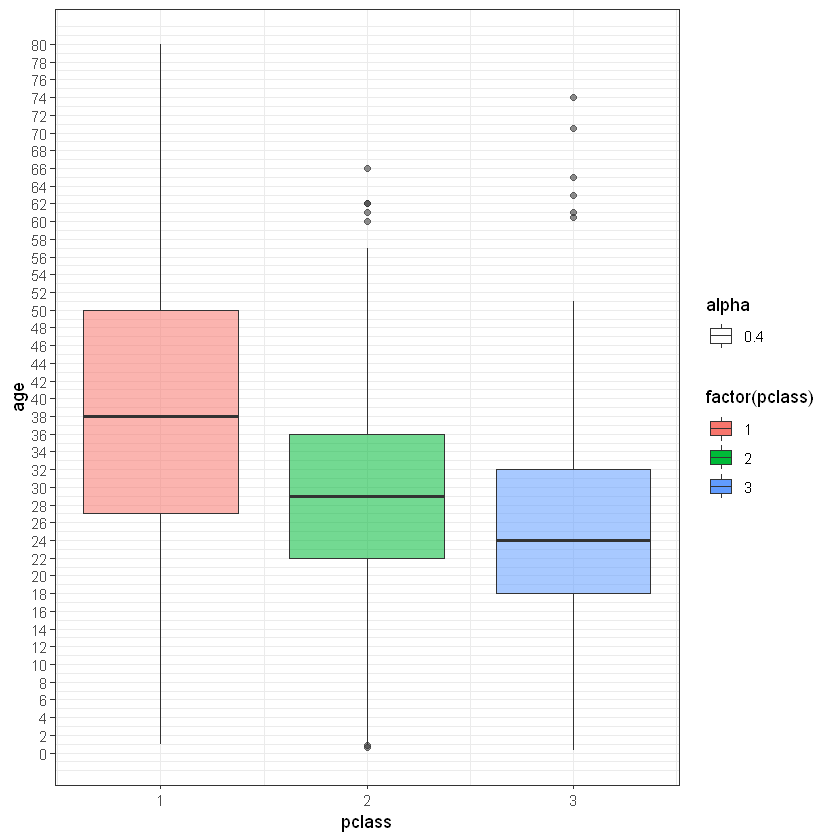

In [28]:
# lets build boxplot for average age in each class

age_plot <- ggplot(titanic_train, aes(pclass, age)) 
age_plot <- age_plot + geom_boxplot(aes(group = pclass, fill = factor(pclass), alpha = 0.4)) # alpha == opacity of chart elements
age_plot <- age_plot + scale_y_continuous(breaks = seq(min(0), max(80), by = 2)) + theme_bw()
age_plot

Середні значення віку для кожного класу пасажирів становлять:

In [29]:
pclass_ages <- titanic_train %>%
    group_by(pclass) %>%
    summarise(mean_age = floor(mean(age, na.rm =T)))
pclass_ages

pclass,mean_age
<int>,<dbl>
1,38
2,29
3,24


In [30]:
titanic_train <- titanic_train %>% 
    mutate(age = ifelse(is.na(age), pclass_ages$mean_age[pclass], age))
           
any(is.na(titanic_train$age)) # check for missing
head(titanic_train)

[1] FALSE

,pclass,survived,sex,age,sibsp,parch,fare,embarked,hascabin
,<int>,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<chr>,<dbl>
1,1,1,female,29.0000,0,0,211.3375,S,1
2,1,1,male,0.9167,1,2,151.5500,S,1
3,1,0,female,2.0000,1,2,151.5500,S,1
4,1,0,male,30.0000,1,2,151.5500,S,1
5,1,0,female,25.0000,1,2,151.5500,S,1
6,1,1,male,48.0000,0,0,26.5500,S,1


In [31]:
titanic_test <- titanic_test %>% 
       mutate(age = ifelse(is.na(age), pclass_ages$mean_age[pclass], age))
any(is.na(titanic_test$age)) # check for missing

[1] FALSE

 /\     /\
{  `---'  }
{  O   O  }
==>  V <==  No need for mice. This data set is completely observed.
 \  \|/  /
  `-----'



,pclass,survived,sex,age,sibsp,parch,fare,embarked,hascabin,
916,1,1,1,1,1,1,1,1,1,0
,0,0,0,0,0,0,0,0,0,0


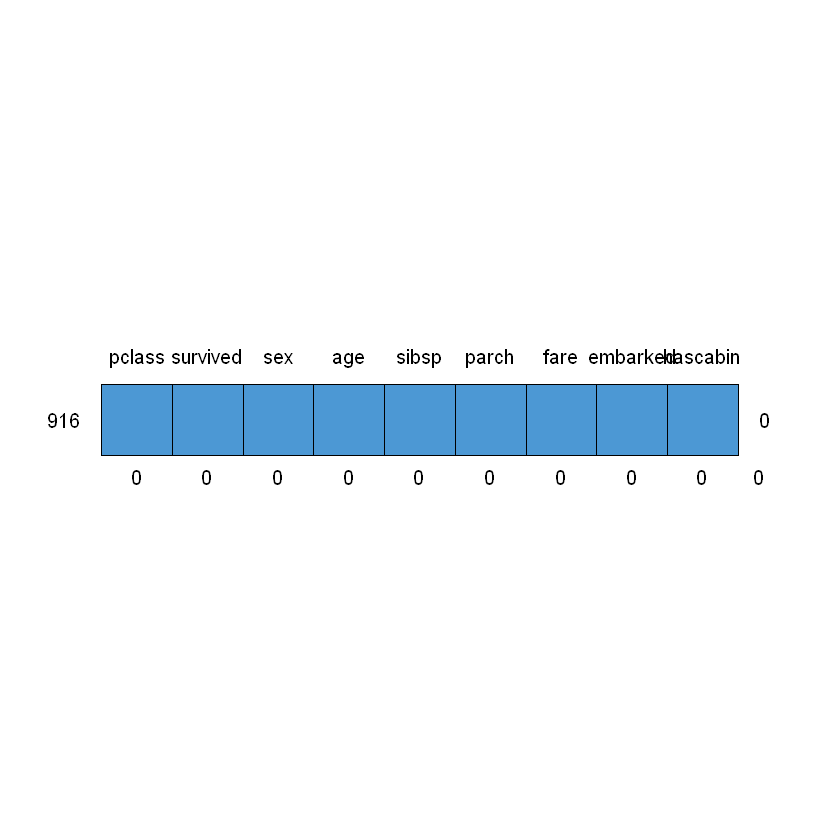

In [32]:
md.pattern(titanic_train) # OK, no missing

 /\     /\
{  `---'  }
{  O   O  }
==>  V <==  No need for mice. This data set is completely observed.
 \  \|/  /
  `-----'



,pclass,survived,sex,age,sibsp,parch,fare,embarked,hascabin,
393,1,1,1,1,1,1,1,1,1,0
,0,0,0,0,0,0,0,0,0,0


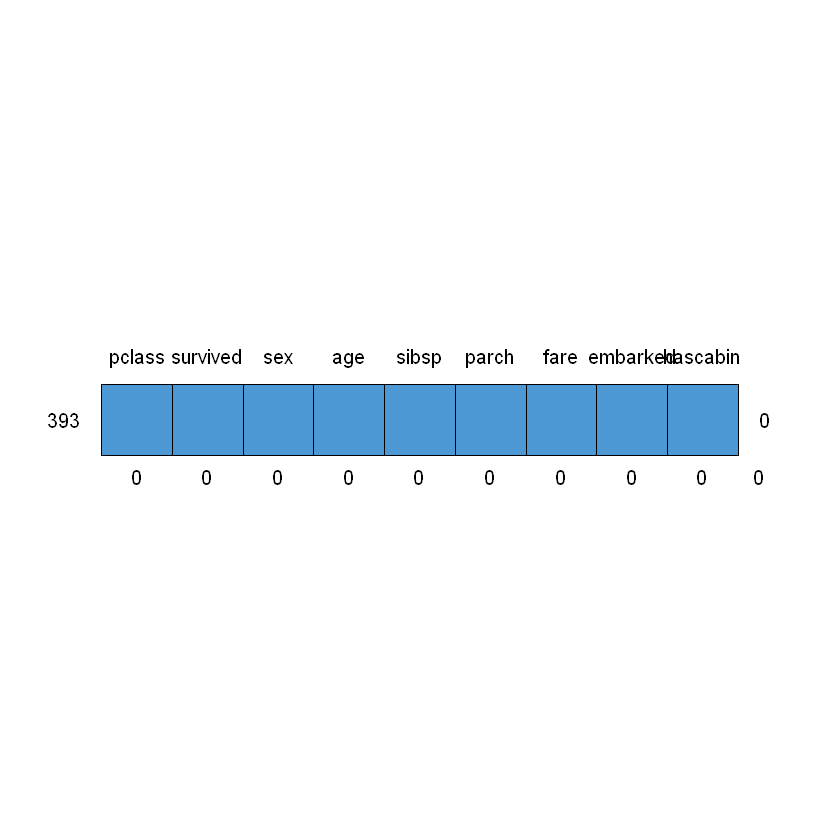

In [33]:
md.pattern(titanic_test) # OK, no missing

---

# Model building

Перед побудовою моделі визначимо категоріальні змінні як фактори (factor), щоб під час моделювання для них було сформовано dummy-змінні.

In [34]:
head(titanic_train)

,pclass,survived,sex,age,sibsp,parch,fare,embarked,hascabin
,<int>,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<chr>,<dbl>
1,1,1,female,29.0000,0,0,211.3375,S,1
2,1,1,male,0.9167,1,2,151.5500,S,1
3,1,0,female,2.0000,1,2,151.5500,S,1
4,1,0,male,30.0000,1,2,151.5500,S,1
5,1,0,female,25.0000,1,2,151.5500,S,1
6,1,1,male,48.0000,0,0,26.5500,S,1


In [35]:
# for train
titanic_train$pclass <- factor(titanic_train$pclass, levels = c(1,2,3))
titanic_train$survived <- factor(titanic_train$survived, levels = c(0, 1))
titanic_train$hascabin<- factor(titanic_train$hascabin, levels = c(0, 1))

titanic_train$embarked <- factor(titanic_train$embarked, levels = c('S', 'C', 'Q'))
titanic_train$sex <- factor(titanic_train$sex, levels = c('female', 'male'))

head(titanic_train)

,pclass,survived,sex,age,sibsp,parch,fare,embarked,hascabin
,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<dbl>,<fct>,<fct>
1,1,1,female,29.0000,0,0,211.3375,S,1
2,1,1,male,0.9167,1,2,151.5500,S,1
3,1,0,female,2.0000,1,2,151.5500,S,1
4,1,0,male,30.0000,1,2,151.5500,S,1
5,1,0,female,25.0000,1,2,151.5500,S,1
6,1,1,male,48.0000,0,0,26.5500,S,1


In [36]:
# use the same levels for factors in test_set
# different ordering data in 

titanic_test$pclass <- factor(titanic_test$pclass, levels = c(1,2,3))
titanic_test$survived <- factor(titanic_test$survived, levels = c(0, 1))
titanic_test$hascabin<- factor(titanic_test$hascabin, levels = c(0, 1))

titanic_test$embarked <- factor(titanic_test$embarked, levels = c('S', 'C', 'Q'))
titanic_test$sex <- factor(titanic_test$sex, levels = c('female', 'male'))

head(titanic_test)

,pclass,survived,sex,age,sibsp,parch,fare,embarked,hascabin
,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<dbl>,<fct>,<fct>
7,1,1,female,63,1,0,77.9583,S,1
11,1,0,male,47,1,0,227.5250,C,1
12,1,1,female,18,1,0,227.5250,C,1
13,1,1,female,24,0,0,69.3000,C,1
17,1,0,male,24,0,1,247.5208,C,1
20,1,0,male,36,0,0,75.2417,C,1


Для побудови логістичної регресії використовується функція `glm()`. Формула `survived ~ .` означає, що у модель будуть відібрані усі параметри із вибірки, а survived буде використано як вихідну змінну. `family = binomial(link = "logit")` вказує на використання логістиної регресії.

In [37]:
def_glm <- glm(formula = survived ~ ., family = binomial(link = "logit"), data = titanic_train)
summary(def_glm)


Call:
glm(formula = survived ~ ., family = binomial(link = "logit"), 
    data = titanic_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5558  -0.6169  -0.4128   0.5801   2.6250  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.748e+00  5.167e-01   5.318 1.05e-07 ***
pclass2     -2.653e-01  3.772e-01  -0.703 0.481831    
pclass3     -1.397e+00  3.907e-01  -3.574 0.000351 ***
sexmale     -2.753e+00  1.999e-01 -13.771  < 2e-16 ***
age         -3.423e-02  7.987e-03  -4.285 1.83e-05 ***
sibsp       -3.144e-01  1.111e-01  -2.829 0.004672 ** 
parch       -7.658e-02  1.196e-01  -0.640 0.521911    
fare         4.771e-05  2.313e-03   0.021 0.983541    
embarkedC    6.002e-01  2.336e-01   2.569 0.010193 *  
embarkedQ   -1.329e-01  3.185e-01  -0.417 0.676547    
hascabin1    1.008e+00  3.247e-01   3.104 0.001912 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family take

Параметри з _***_ вказують на значимість показника у моделі. Здійснимо прогноз по тренувальній вибірці:

And test build model with an other package `caret` explained before in train/test/validation splitting paragraph.

In [38]:
# install.packages("e1071")

In [39]:
#library(e1071) # required by caret
suppressMessages(library(caret))

# this is wrapper function for training different models
caret_glm = train(survived ~ ., # formula
                    data = titanic_train, # data for model training     
                    method = 'glm', # model building algorithm, glm
                    family = "binomial",
                    ) # data preprocessing techniques, normalization and scaling
summary(caret_glm)

Loading required package: lattice




Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5558  -0.6169  -0.4128   0.5801   2.6250  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.748e+00  5.167e-01   5.318 1.05e-07 ***
pclass2     -2.653e-01  3.772e-01  -0.703 0.481831    
pclass3     -1.397e+00  3.907e-01  -3.574 0.000351 ***
sexmale     -2.753e+00  1.999e-01 -13.771  < 2e-16 ***
age         -3.423e-02  7.987e-03  -4.285 1.83e-05 ***
sibsp       -3.144e-01  1.111e-01  -2.829 0.004672 ** 
parch       -7.658e-02  1.196e-01  -0.640 0.521911    
fare         4.771e-05  2.313e-03   0.021 0.983541    
embarkedC    6.002e-01  2.336e-01   2.569 0.010193 *  
embarkedQ   -1.329e-01  3.185e-01  -0.417 0.676547    
hascabin1    1.008e+00  3.247e-01   3.104 0.001912 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1218.4  on 915  degrees of freedom
Residual deviance: 

> You can see that we got the same variables significansy in both models, but coefficients are different. Lets check what model building algorithm is better.

To compare our modeling resutls for train lets create special data frames:

In [40]:
train_check <- titanic_train %>% 
    select(survived) %>%
    mutate(predicted_def = predict(def_glm, type = 'response', newdata = titanic_train), # predicted by default glm function
           predicted_caret = predict(caret_glm, type = 'prob', newdata = titanic_train)[, 2]) # predicted by caret train algorithm

head(train_check)

,survived,predicted_def,predicted_caret
,<fct>,<dbl>,<dbl>
1,1,0.9412193,0.9412193
2,1,0.6250488,0.6250488
3,0,0.9618407,0.9618407
4,0,0.3812235,0.3812235
5,0,0.9198190,0.9198190
6,1,0.3455040,0.3455040


As you see for logistic regression results are the same, so we can use default algorithm. But `train()` method is very powerfull with desicion trees, boosting, random forest, neural network and other complex algorithms.

---

## Model accuracy check

Lets create new datasets for train and test results storing. We will use them 

In [41]:
train_results <- titanic_train %>% 
    select(survived) %>%
    mutate(predicted = predict(def_glm, type = 'response', newdata = titanic_train),
          residuals = residuals(def_glm, type = "response"))

test_results <- titanic_test %>%
    select(survived) %>%
    mutate(predicted = predict(def_glm, type = 'response', newdata = titanic_test))

head(test_results)

,survived,predicted
,<fct>,<dbl>
7,1,0.7839711
11,0,0.4233024
12,1,0.9688239
13,1,0.9717471
17,0,0.6718810
20,0,0.5925107


The next stage is converting out predicted probabilities into event classes 1/0. By default you can do this using next condition `predicted == 1 if prob >= 0.5 and 0 if prob < 0.5`.

In this case `0.5` is cut-off line or classification splitter. So, lets do this for both train and test.

In [42]:
train_results <- train_results %>%
    mutate(survived_05 = as.factor(ifelse(predicted >= 0.5, 1 , 0)))

test_results <- test_results %>%
    mutate(survived_05 = as.factor(ifelse(predicted >= 0.5, 1 , 0)))

head(test_results)

,survived,predicted,survived_05
,<fct>,<dbl>,<fct>
7,1,0.7839711,1
11,0,0.4233024,0
12,1,0.9688239,1
13,1,0.9717471,1
17,0,0.6718810,1
20,0,0.5925107,1


Для демонстрації переглянемо графік реальних та прогнозованих/модельованих значень survived.

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."


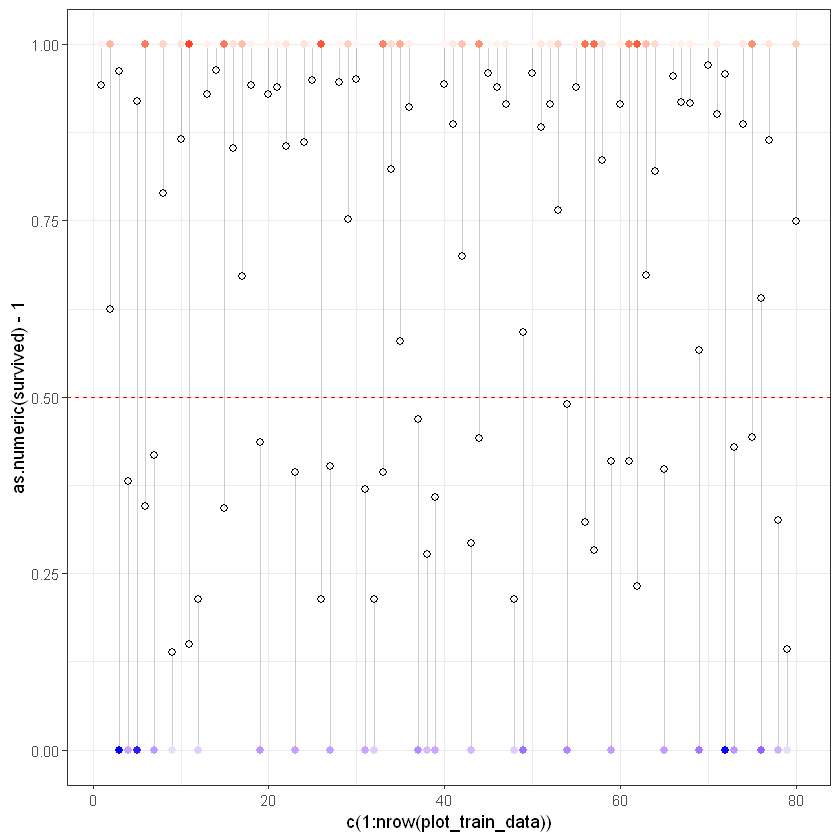

In [43]:
plot_train_data <- train_results[0:80,]

ggplot(plot_train_data, aes(x = c(1:nrow(plot_train_data)), y = as.numeric(survived)-1)) +
  geom_segment(aes(xend = c(1:nrow(plot_train_data)), yend = predicted), alpha = .2) +
  geom_point(aes(color = residuals), size = 2) +
  scale_color_gradient2(low = "blue", mid = "white", high = "red") +
  guides(color = FALSE) +
  geom_point(aes(y = predicted), shape = 1, size = 2) +
  geom_hline(yintercept=0.5, linetype="dashed", color = "red") +
  theme_bw()

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windowsWarning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."


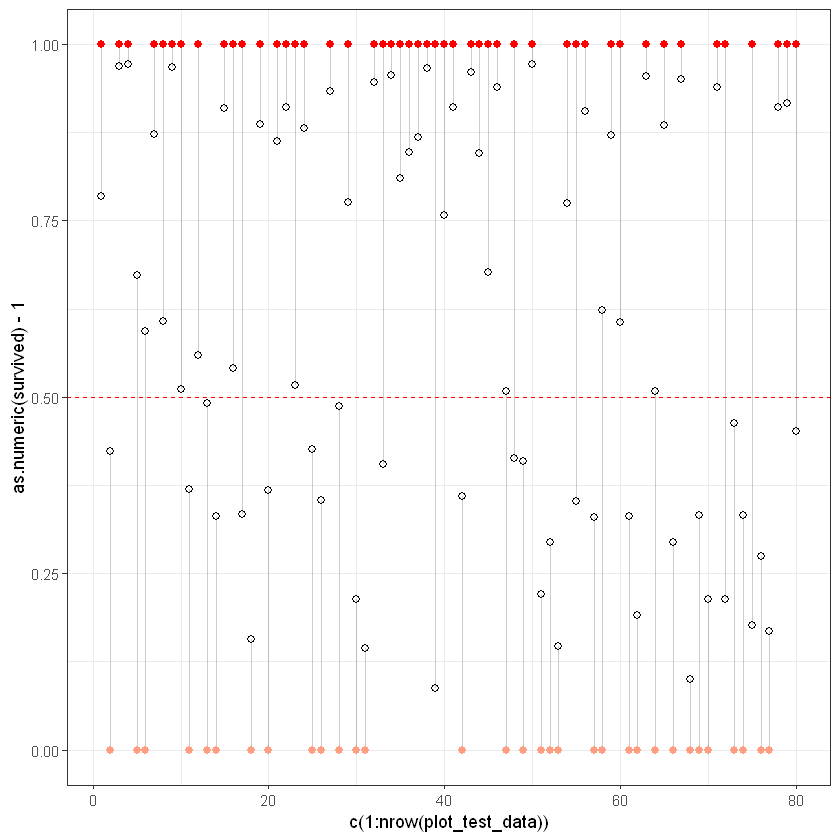

In [44]:
plot_test_data <- test_results[0:80,]

ggplot(plot_test_data, aes(x = c(1:nrow(plot_test_data)), y = as.numeric(survived)-1)) +
  geom_segment(aes(xend = c(1:nrow(plot_test_data)), yend = predicted), alpha = .2) +
  # Увага, для тестової вибірки є зміни, за точку відліку враховується вихідна змінна
  geom_point(aes(color =  as.numeric(survived)), size = 2) +
  scale_color_gradient2(low = "blue", mid = "white", high = "red") +
  guides(color = FALSE) +
  geom_point(aes(y = predicted), shape = 1, size = 2) +
  geom_hline(yintercept=0.5, linetype="dashed", color = "red") +
  theme_bw()

Побудуємо confusion matrix для тренувальної вибірки:

In [45]:
print("Train CM:")
table(train_results$survived, train_results$survived_05)

[1] "Train CM:"


   
      0   1
  0 488  78
  1 104 246

In [46]:
print("Test CM:")
table(test_results$survived, test_results$survived_05)

[1] "Test CM:"


   
      0   1
  0 206  37
  1  46 104

Більш детальну статистику по `confusion matrix` можна отримати скориставшись методом `confusionMatrix()` з пакету `caret`.

In [47]:
# train
caret::confusionMatrix(train_results$survived, train_results$survived_05, positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 488  78
         1 104 246
                                         
               Accuracy : 0.8013         
                 95% CI : (0.774, 0.8267)
    No Information Rate : 0.6463         
    P-Value [Acc > NIR] : < 2e-16        
                                         
                  Kappa : 0.5732         
                                         
 Mcnemar's Test P-Value : 0.06386        
                                         
            Sensitivity : 0.7593         
            Specificity : 0.8243         
         Pos Pred Value : 0.7029         
         Neg Pred Value : 0.8622         
             Prevalence : 0.3537         
         Detection Rate : 0.2686         
   Detection Prevalence : 0.3821         
      Balanced Accuracy : 0.7918         
                                         
       'Positive' Class : 1              
                                         

In [48]:
# test
caret::confusionMatrix(test_results$survived, test_results$survived_05, positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 206  37
         1  46 104
                                          
               Accuracy : 0.7888          
                 95% CI : (0.7451, 0.8281)
    No Information Rate : 0.6412          
    P-Value [Acc > NIR] : 1.522e-10       
                                          
                  Kappa : 0.5474          
                                          
 Mcnemar's Test P-Value : 0.3799          
                                          
            Sensitivity : 0.7376          
            Specificity : 0.8175          
         Pos Pred Value : 0.6933          
         Neg Pred Value : 0.8477          
             Prevalence : 0.3588          
         Detection Rate : 0.2646          
   Detection Prevalence : 0.3817          
      Balanced Accuracy : 0.7775          
                                          
       'Positive' Class : 1               
                              

One of most often qustions is "What cutoff line should be selected?". You can have 2 answers:

- [x] You can select optimal cutoff using best classification criteria: while you best classify both 1 and 0 events

- [x] You can select cutoff than help solve your business tasks, for, example, you need to select only 20% most risky clients, so, set your cutoff to 0.8. Or you need concrete count of clients, for example, 1000 and it can be at 0.94 line sometimes if you have big database. 

Lets try to find optimal cutoff with `InformationValue` package and special method:

In [49]:
suppressMessages(library(InformationValue))

opt_cutoff <- optimalCutoff(train_results$survived, train_results$predicted)
opt_cutoff


Attaching package: 'InformationValue'


The following objects are masked from 'package:caret':

    confusionMatrix, precision, sensitivity, specificity




[1] 0.5566741

Lest compare confusion matrix for previous 0.5 cutoff and current `opt_cutoff`

In [50]:
# cutoff = 0.5
caret::confusionMatrix(test_results$survived, test_results$survived_05, positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 206  37
         1  46 104
                                          
               Accuracy : 0.7888          
                 95% CI : (0.7451, 0.8281)
    No Information Rate : 0.6412          
    P-Value [Acc > NIR] : 1.522e-10       
                                          
                  Kappa : 0.5474          
                                          
 Mcnemar's Test P-Value : 0.3799          
                                          
            Sensitivity : 0.7376          
            Specificity : 0.8175          
         Pos Pred Value : 0.6933          
         Neg Pred Value : 0.8477          
             Prevalence : 0.3588          
         Detection Rate : 0.2646          
   Detection Prevalence : 0.3817          
      Balanced Accuracy : 0.7775          
                                          
       'Positive' Class : 1               
                              

In [51]:
# opt_cutoff

test_results <- test_results %>%
    mutate(survived_opt = ifelse(predicted >= opt_cutoff, 1, 0)) # calculate optima cutoff

caret::confusionMatrix(test_results$survived, factor(test_results$survived_opt), positive = "1")


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 215  28
         1  53  97
                                          
               Accuracy : 0.7939          
                 95% CI : (0.7505, 0.8328)
    No Information Rate : 0.6819          
    P-Value [Acc > NIR] : 5.041e-07       
                                          
                  Kappa : 0.5489          
                                          
 Mcnemar's Test P-Value : 0.007661        
                                          
            Sensitivity : 0.7760          
            Specificity : 0.8022          
         Pos Pred Value : 0.6467          
         Neg Pred Value : 0.8848          
             Prevalence : 0.3181          
         Detection Rate : 0.2468          
   Detection Prevalence : 0.3817          
      Balanced Accuracy : 0.7891          
                                          
       'Positive' Class : 1               
                              

`Accuracy : 0.7888` -> `Accuracy : 0.7939`   increased

 `Balanced Accuracy : 0.7775` -> `Balanced Accuracy : 0.7891` inreased

In this case if you need classificate more clients as `survived` decrease cutoff, for less `survived` increase it.

And the last one characteristics we will use is ROC-curve:

[1] 0.8573

[1] 0.7146

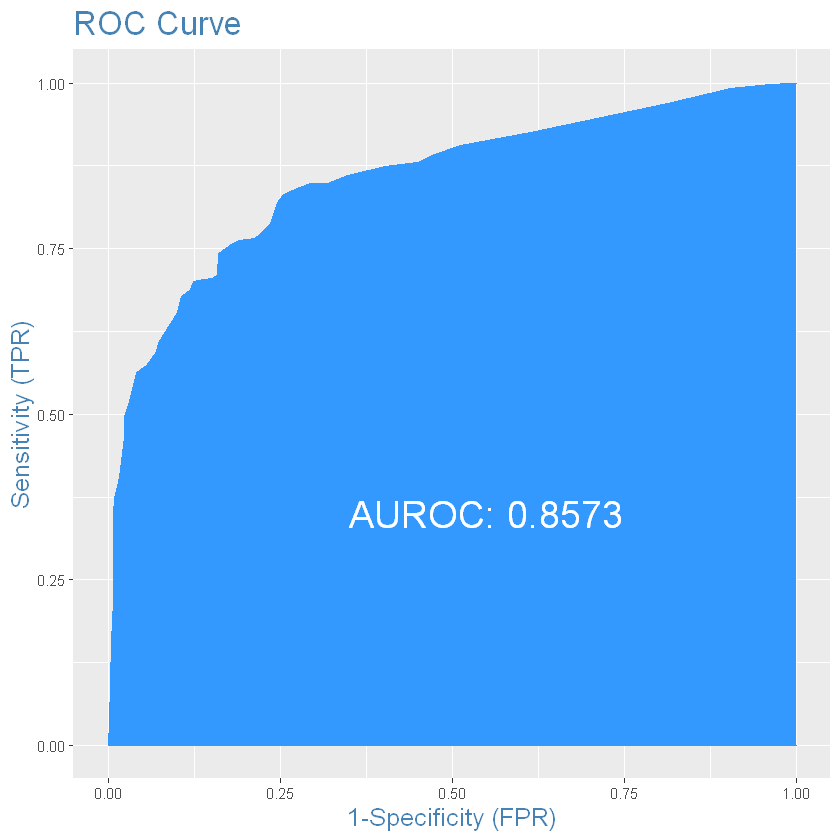

In [52]:
# for train
plotROC(train_results$survived, train_results$predicted) # from InformationValue package
auroc <- round(AUROC(train_results$survived, train_results$predicted), 4)
auroc
gini <- 2*auroc - 1
gini

#if ROC is fully filled and AUROC close to 1 on train, its very big possibility that our model is overfitted

[1] 0.8142

[1] 0.6284

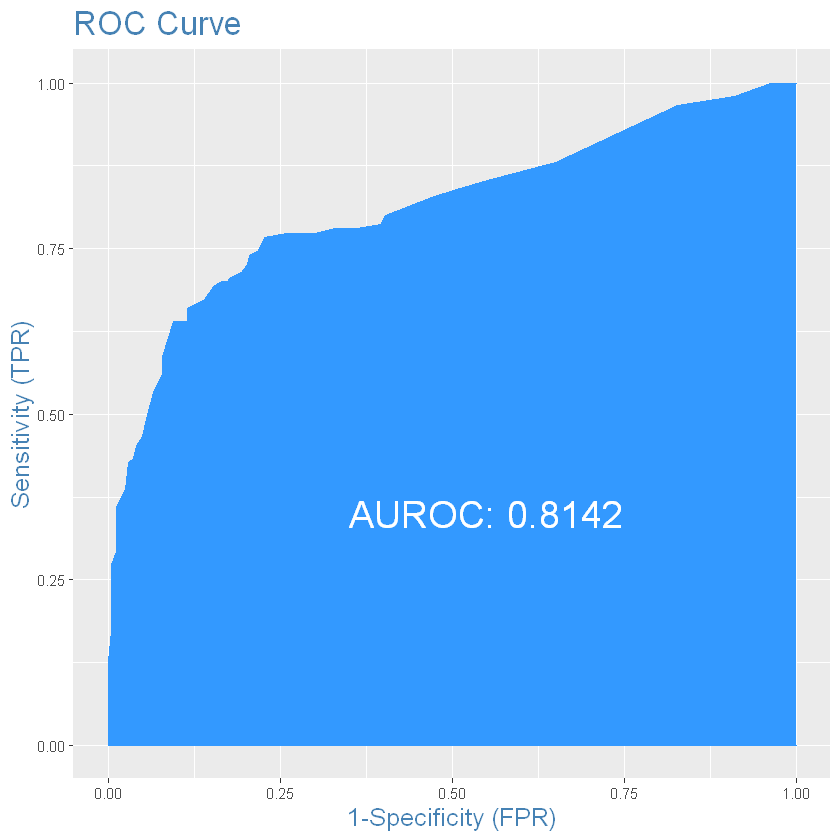

In [53]:
# for test
plotROC(test_results$survived, test_results$predicted) # from InformationValue package
auroc <- round(AUROC(test_results$survived, test_results$predicted), 4)
auroc
gini <- 2*auroc - 1
gini

#if ROC is fully filled and AUROC close to 1 on test, its very big possibility that you test sample contains

You should made your conclusions about test set, because test results shows how model predicting events on data it not know before. Test data is very close to prediction data but did not have target variable, so you can check accuracy on prediction set after some time cheking you experiment on real-world situation.